In [1]:
import pandas as pd
import numpy as np
from pandas import read_excel
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn.metrics as sk

from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score

C:\Users\Olya\miniconda3\envs\prak\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Olya\miniconda3\envs\prak\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\Olya\miniconda3\envs\prak\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
from fun import DFtest
from fun import Integration_order

In [3]:
data = pd.read_excel('data.xlsx', index_col=0)
data.tail()

,Value
Date,
1988-08-01,63.8851
1988-09-01,63.7040
1988-10-01,64.0220
1988-11-01,64.1173
1988-12-01,64.4210


**Часть 1**

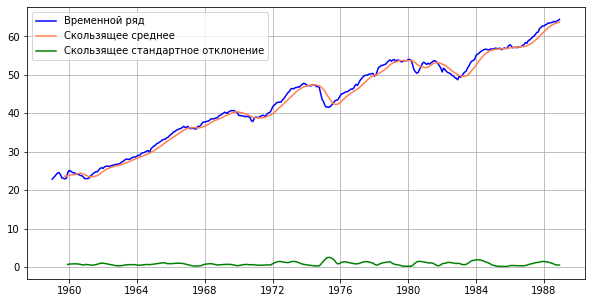

In [4]:
values=data.Value
plt.figure(figsize=(10,5))
plt.plot(data.Value,'b', label = 'Временной ряд')
plt.plot(data.Value.rolling(window=10).mean(), 'coral', label = 'Скользящее среднее')
plt.plot(data.Value.rolling(window=12).std(), 'green', label = 'Скользящее стандартное отклонение')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

График имеет ярко выраженныйтренд. Из этого следует, что ряд не является стационарным.

Оценим достоверность статистики через тест Дики-Фуллера на нкаличие единичных корней.

In [5]:
    if not DFtest(values):
        print ('Ряд не стационарен (есть единичные корни)')
    else:
        print ('Ряд стационарен (единичных корней нет)')

adf:  -0.2533911799284614
p-value:  0.9318510422993468
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}
Ряд не стационарен (есть единичные корни)


Предположение о нестационарности ряда подтверждены

**Часть 2**

**Аддитивная модель**

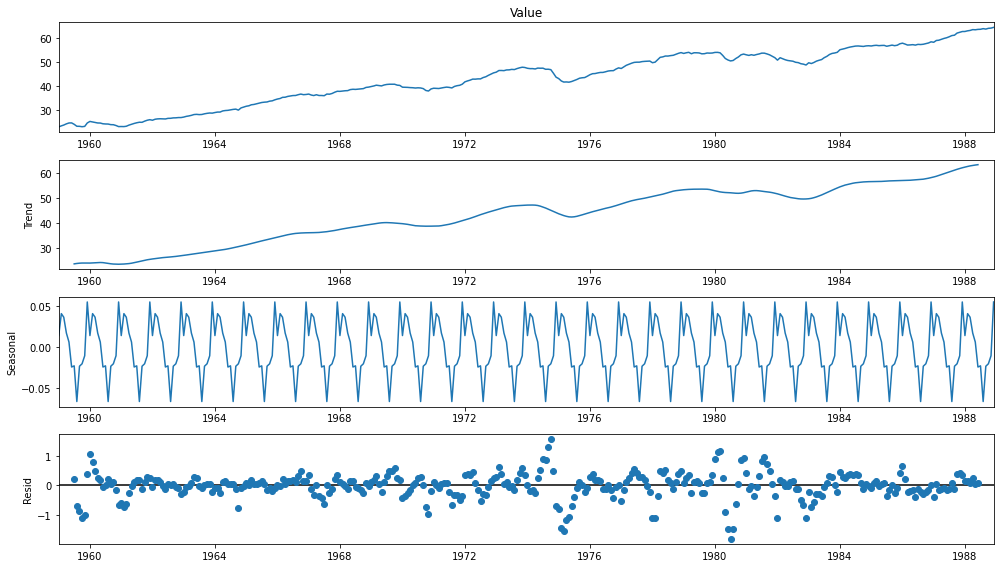

In [6]:
dataset = data
dataset.reset_index(inplace=True)
dataset['Date'] = pd.to_datetime(data['Date']) 
dataset = dataset.set_index('Date') 
rcParams['figure.figsize'] = 14, 8
sm.tsa.seasonal_decompose(dataset.Value, 'additive').plot()
plt.show()

Тренд: Имеются единичные кони, ряд не стационарен

Сезональность: Единичных корней нет, ряд стационарен

Остаток: Единичных корней нет, ряд стационарен

**Мультипикативная модель**

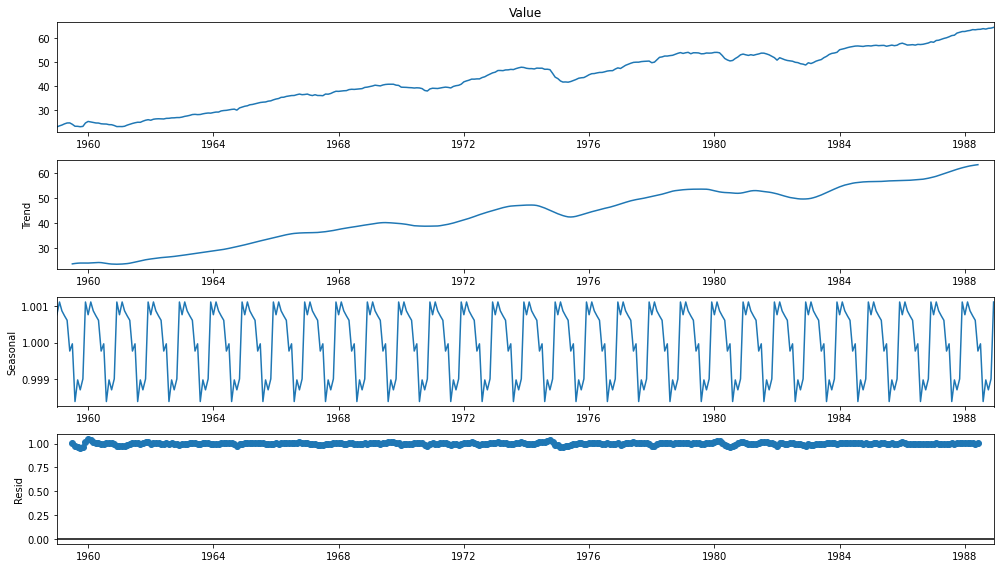

In [7]:
sm.tsa.seasonal_decompose(dataset.Value, 'multiplicate').plot()
plt.show()

Тренд: Имеются единичные кони, ряд не стационарен

Сезональность: Единичных корней нет, ряд стационарен

Остаток: Единичных корней нет, ряд стационарен

**Часть 3**

**Порядок интегрирования ряда**

In [8]:
order , test = Integration_order(data.Value)
print('Порядок интегрированния: ', order)

adf:  -0.2533911799284614
p-value:  0.9318510422993468
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}
adf:  -7.367311495211976
p-value:  9.164149561098514e-11
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}
Порядок интегрированния:  1


C:\Users\Olya\miniconda3\envs\prak\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


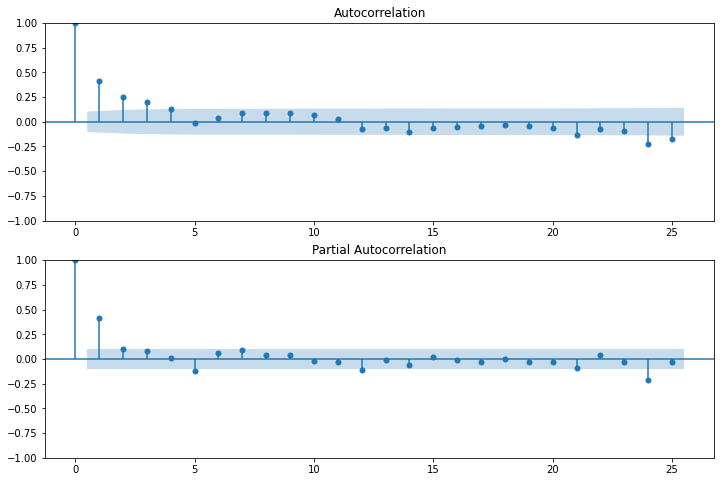

In [9]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(test, lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(test, lags=25, ax=ax2)

Для построения модели необходимо выбрать 3 параметра: p - порядок компоненты AR, d - порядок интегрированного ряда (уже известна), q - порядок компоненты MA

ACF: определяет q. По коррелограмме видно, что после 3-4 лага значения функции падают

PACF: p = 1/5/12/24 - эти лаги сильнее отличны от нуля.

Из этого выберем три модели.

In [10]:
model1 = sm.tsa.ARIMA(data.Value.squeeze(), order=(1, 1, 3)).fit()
model2 = sm.tsa.ARIMA(data.Value.squeeze(), order=(12, 1, 3)).fit()
model3 = sm.tsa.ARIMA(data.Value.squeeze(), order=(24, 1, 4)).fit()

C:\Users\Olya\miniconda3\envs\prak\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Olya\miniconda3\envs\prak\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
data_test = pd.read_excel("testing.xlsx")
data_test.tail()

pr1 = model1.predict(start=data.shape[0],
                        end=data.shape[0]+data_test.shape[0]-1, typ='levels')
pr2 = model2.predict(start=data.shape[0],
                        end=data.shape[0]+data_test.shape[0]-1, typ='levels')
pr3 = model3.predict(start=data.shape[0],
                        end=data.shape[0]+data_test.shape[0]-1, typ='levels')

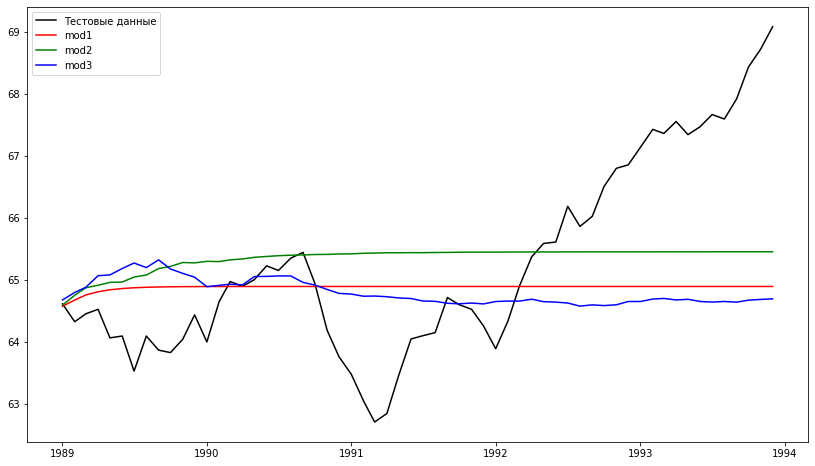

In [12]:
plt.plot(data_test.Date, data_test.Value, 'black', label = 'Тестовые данные')
plt.plot(data_test.Date, pr1, 'r', label = 'mod1')
plt.plot(data_test.Date, pr2, 'g', label = 'mod2')
plt.plot(data_test.Date, pr3, 'b', label = 'mod3')
plt.legend(loc='upper left')
plt.show()

Рассчитаем коэффициент детерминации

In [13]:
r21 = sk.r2_score(data_test.Value, pr1)
r22 = sk.r2_score(data_test.Value, pr2)
r23 = sk.r2_score(data_test.Value, pr3)
print('r2 model1:', r21)
print('r2 model2:', r22)
print('r2 model3:', r23)

r2 model1: -0.0479622954476262
r2 model2: 0.06620224702125188
r2 model3: -0.20690609126133253


In [14]:
print('AIC model1:', model1.aic)
print('AIC model2:', model2.aic)
print('AIC model3:', model3.aic)

AIC model1: 258.92623174546213
AIC model2: 262.81553262673464
AIC model3: 265.2639863085629


Наилучшая модль - модель с наименьшимзначением критерия AIC. Это модель 1.